# Feature Selection 1 (Designed Feature Selection) - subject averaged data from the motor task.  

#### In this notebook we will do some analysis of the motor fMRI data which has already been averaged across samples in each participant.

#### The motor task is a good place to start, because we can use a simple fact to guide us.  Movement of the left side of the body involves activity of the right motor cortex, while movement of the right side of the body involves activity of the left motor cortex.  

#### In this tutorial, the main goal is to understand how feature selection can guide our design of a classification algorithm and improve its performance. 

#### load the the modules needed

In [6]:
import numpy as np 
from matplotlib import pyplot as plt 
from hdf5storage import loadmat, savemat 
from nilearn import plotting,datasets

In [7]:
#IF YOU MOVED THE PROGRAMS INTO THE TOP LEVEL OF hcp_task
#hcppath = './'
#datapath = './processed'
#or else write the full path
hcppath = '/Applications/neuralanalytics/fmri/hcp_task/'
datapath = hcppath+'processed/'


#### Load the region labels file, regions.npy

In [8]:
regions = np.load(hcppath+'regions.npy') # this is the file 
roi_names = regions[:,0] # these are the names of each of 360 roi from the parcellation.
network_names = regions[:,1] # these are the networks each roi "belongs" to
networks = np.unique(regions[:,1]) # these are the unique network names 


#### Load the hcp atlas file. 

In [9]:
atlas = dict(np.load(hcppath+'hcp_atlas.npz'))
fsaverage = datasets.fetch_surf_fsaverage()

#### Load the fMRI data

In [10]:
data = loadmat(datapath+'MOTOR_fmri_subjectaverage.mat')

In [11]:
data.keys()

dict_keys(['condition_index', 'conditions', 'fmri', 'nconditions', 'nregions', 'nsubjects', 'subject', 'task'])

#### Extract the data in the dictionary into separate variables

In [12]:
condition_index = data['condition_index']
conditions = data['conditions']
fmri = data['fmri']
nconditions = data['nconditions']
nregions = data['nregions']
nsubjects = data['nsubjects']
subject = data['subject']
task = data['task']

## README 

#### condition_index - index for each data sample, indicating the experimental condition 
#### conditions - conditions in the experiment 
#### fmri - fmri data averaged over participants, nregions x (nsubjects x nconditions)
#### nconditions - number of conditions
#### nregions - number of regions (always 360)
#### nsubjects - number of subjects (always 100)
#### subject - indexes which subject each average comes from. 
#### task - which task the data comes from.  

In [13]:
print(conditions)

['lf', 'rf', 'lh', 'rh', 't', 'cue']


#### For the MOTOR task 
* #### 'lf' - left foot, condition_index = 0 
* #### 'rf' - right foot, condition_index = 1
* #### 'lh' - left hand, condition_index = 2 
* #### 'rh' - right hand, condition_index = 3
* #### 't' - tongue, condition_index = 4 
* #### 'cue' - when the visual cue was presented (no movement), condition_index = 5



#### 1.  First I'm going to compute some averages by condition. 

In [14]:
avg_fmri = dict()
#lh 
avg_fmri['lh'] = np.mean(fmri[:,condition_index == 0],axis = 1)
avg_fmri['rh'] = np.mean(fmri[:,condition_index == 1],axis = 1)
avg_fmri['lf'] = np.mean(fmri[:,condition_index == 2],axis = 1)
avg_fmri['rf'] = np.mean(fmri[:,condition_index == 3],axis = 1)
avg_fmri['t'] = np.mean(fmri[:,condition_index == 4],axis = 1)
avg_fmri['cue'] = np.mean(fmri[:,condition_index == 5],axis = 1)


### Let's plot the difference between conditions. Before I do that, I am going to z-score the data

#### The variables in the experiment are the 360 ROI.   I must make the mean of these variables zero in order to center the data on zero.  

In [15]:
from scipy.stats import zscore
z = zscore(fmri)

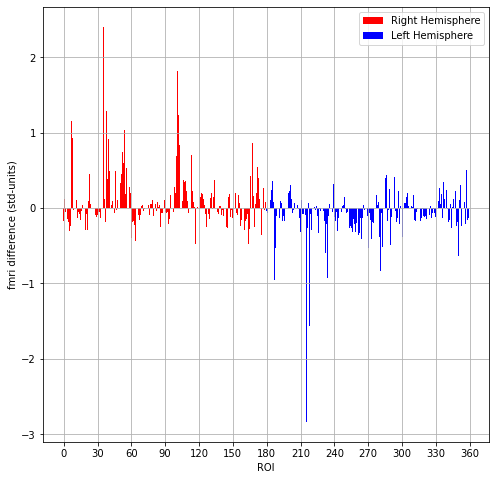

In [16]:
#To comparse left foor to right foot, I see that condition_index is 0, and condition_index is 1.  
diff = np.mean(z[:,condition_index == 0],axis =1)-np.mean(z[:,condition_index == 1],axis = 1)
plt.figure(figsize = (8,8))
#plt.plot(diff)
plt.bar(np.arange(180),diff[0:180],color = 'r')
plt.bar(np.arange(180,360,1),diff[180:360],color = 'b')
plt.xticks(range(0,390,30))
plt.legend(('Right Hemisphere','Left Hemisphere'))
plt.xlabel('ROI')
plt.ylabel('fmri difference (std-units)')
plt.grid()

### 3. Lets identify the region with the strongest positive and negative difference  

In [17]:
r1= np.argmax(diff)
print(roi_names[r1],network_names[r1])
r2 = np.argmin(diff)
print(roi_names[r2],network_names[r2])

R_5m Somatomotor
L_5m Somatomotor


#### Interestingly - Neither of these regions is the primary motor cortex (Area 4)
#### Area 5 is part of the superior parietal lobule, and is right next to somatosensory cortex


In [18]:
surf_label = diff[atlas['labels_R']] ## This maps the 360 values onto every voxel on the ROI in the brain.  
plotting.view_surf(fsaverage['pial_right'],surf_label,symmetric_cmap = True,title = 'lf-rf',black_bg = True)

In [19]:
surf_label = diff[atlas['labels_L']] ## This maps the 360 values onto every voxel on the ROI in the brain.  
plotting.view_surf(fsaverage['pial_left'],surf_label,symmetric_cmap = True,title = 'lf-rf',black_bg = True)

#### Here I identify the 10 regions with largest differences. 

In [20]:
n = 10
ordered_index = np.argsort(np.abs(diff)) # sorts into ascending order 
topn = ordered_index[-n:] #take the last n
for j in range(len(topn)):
    print(roi_names[topn[j]],network_names[topn[j]], diff[topn[j]])


# this shows you the effect size with the z score 
# all the biggest difference is in the somatoomot system with left and right 


R_3b Somatomotor 0.9332513871441703
L_4 Somatomotor -0.954624246202002
R_6mp Somatomotor 1.0368455941367758
R_4 Somatomotor 1.1566771823870952
R_52 Auditory 1.2335453128430511
R_5L Somatomotor 1.2911761096235903
L_5L Somatomotor -1.565323734093445
R_OP2-3 Somatomotor 1.813147842567039
R_5m Somatomotor 2.406278124374048
L_5m Somatomotor -2.8381840862007794


#### Now let's run the LDA analysis and try to classify the movement. 

In [21]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
z_T = np.transpose(z)
from sklearn.model_selection import KFold 
kf = KFold(n_splits = 5,shuffle = True)
errors = 0
predictions = np.zeros(np.shape(z_T)[0])
probability = np.zeros((len(predictions),nconditions))
for train_index, test_index in kf.split(z_T):
#    print("TRAIN:", train_index, "TEST:", test_index)
    data_train = z_T[train_index]
    data_test = z_T[test_index]
    Label_train= condition_index[train_index] 
    Label_test = condition_index[test_index]
    lda = LDA(n_components=1)
    data_model = lda.fit(data_train, Label_train)
    predict = lda.predict(data_test)
    test = Label_test == predict
    errors = errors + sum(~test)
    predictions[test_index] = predict
    probability[test_index,:] = lda.predict_proba(data_test)
errorrate = errors/len(condition_index)
accuracy = 100*(1-errorrate)
print(accuracy)

90.66666666666666


#### Lets compute a confusion matrix

In [22]:
confusion_matrix = np.zeros((nconditions,nconditions))
for j in range(nconditions):
    values, counts = np.unique(predictions[condition_index == j],return_counts = True)
    confusion_matrix[j,values.astype(int)] = counts
print(confusion_matrix)  

#we are insteredt in smoething sementaic pattern in the errors that is visible and can be fixed 
# i should get an 100 in the dignals and number in the other areas 
# CONFUSION IN THE FIRST AND SECOND COLUMSN     

# CANNOT TELL THE DIFFERENCE IN LEFT AND RIGH FOT AND HAND 


[[90.  6.  1.  0.  2.  1.]
 [ 5. 88.  2.  3.  2.  0.]
 [ 0.  2. 92.  1.  3.  2.]
 [ 4.  1.  1. 91.  3.  0.]
 [ 3.  1.  0.  1. 92.  3.]
 [ 4.  0.  2.  0.  3. 91.]]


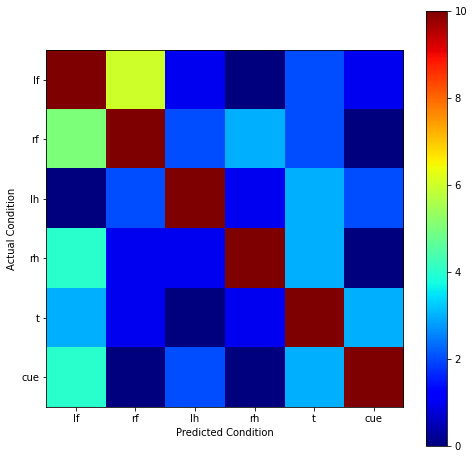

In [23]:
#make a nice plot of the confusion matrix
plt.figure(figsize = (8,8))
plt.imshow(confusion_matrix,vmin = 0, vmax = 10, cmap = 'jet')
plt.xticks(range(6),labels = conditions)
plt.yticks(range(6),labels = conditions)
plt.xlabel('Predicted Condition')
plt.ylabel('Actual Condition')
plt.colorbar()

#### LDA Analysis with all the data.  

In [24]:
fmri_lda = LDA(n_components=1)
fmri_model = fmri_lda.fit(z_T, condition_index)
fmri_predict = fmri_lda.transform(z_T)
fmri_coef = fmri_lda.coef_

#### make a map of the weights.  

In [25]:
ci = 4 # index for the condition
surf_label = fmri_coef[ci,atlas['labels_L']] ## This maps the 360 values onto every voxel on the ROI in the brain.  
plotting.view_surf(fsaverage['infl_left'],surf_label,symmetric_cmap = True, title = conditions[ci],black_bg = True, vmax = 20)

In [26]:
n = 8
for j in range(nconditions):
    r1 = np.argsort(np.abs(fmri_coef[j,:]))
    r1 = np.flipud(r1) #now sorted from highest to lowest
    print(conditions[j])
    print(roi_names[r1[-n:]])
    print(network_names[r1[-n:]])

# caalfuting one over all the rest o9
#
# h

lf
['R_6a' 'L_11l' 'L_IFJp' 'R_FST' 'L_a24pr' 'L_5L' 'L_TGd' 'R_7Am']
['Language' 'Frontopariet' 'Frontopariet' 'Visual2' 'Cingulo-Oper'
 'Somatomotor' 'Posterior-Mu' 'Cingulo-Oper']
rf
['R_13l' 'R_47m' 'R_i6-8' 'R_STSdp' 'R_DVT' 'R_PIT' 'R_TGv' 'R_a9-46v']
['Frontopariet' 'Posterior-Mu' 'Frontopariet' 'Default' 'Visual1'
 'Visual2' 'Default' 'Frontopariet']
lh
['R_PHT' 'R_44' 'R_FOP3' 'R_9a' 'R_33pr' 'R_6mp' 'R_i6-8' 'R_PGp']
['Language' 'Default' 'Cingulo-Oper' 'Posterior-Mu' 'Cingulo-Oper'
 'Somatomotor' 'Frontopariet' 'Language']
rh
['R_POS1' 'R_LO2' 'L_MI' 'L_p24' 'R_LO3' 'L_a24' 'R_PFop' 'L_24dv']
['Posterior-Mu' 'Visual2' 'Cingulo-Oper' 'Cingulo-Oper' 'Visual2'
 'Posterior-Mu' 'Cingulo-Oper' 'Somatomotor']
t
['L_A4' 'L_PHT' 'L_FOP5' 'L_p9-46v' 'L_8Ad' 'L_LBelt' 'L_4' 'L_FOP3']
['Auditory' 'Language' 'Cingulo-Oper' 'Frontopariet' 'Posterior-Mu'
 'Auditory' 'Somatomotor' 'Cingulo-Oper']
cue
['R_a24' 'L_10v' 'L_VIP' 'L_MI' 'L_TGd' 'R_AVI' 'R_EC' 'R_VMV1']
['Posterior-Mu' 'Posterior

#### Lets visualize the distribution of outputs of each projection. 

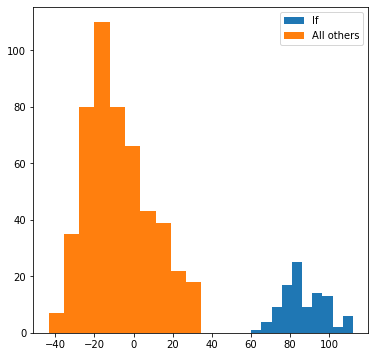

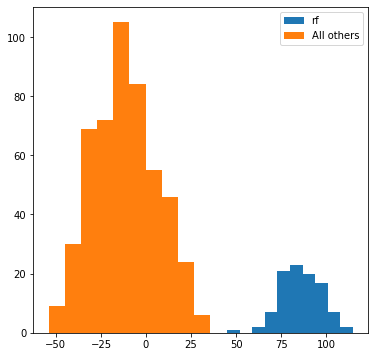

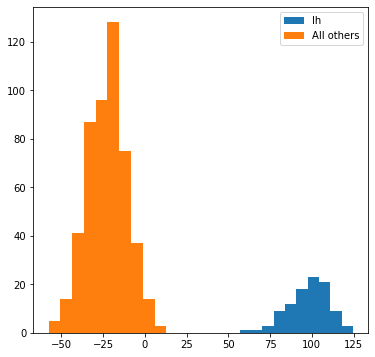

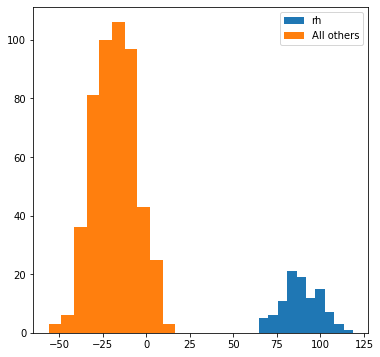

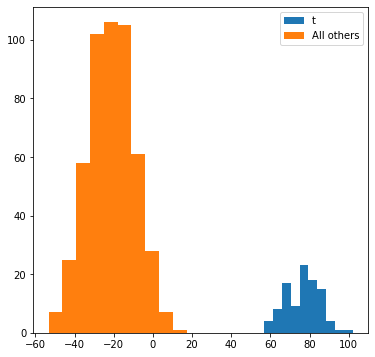

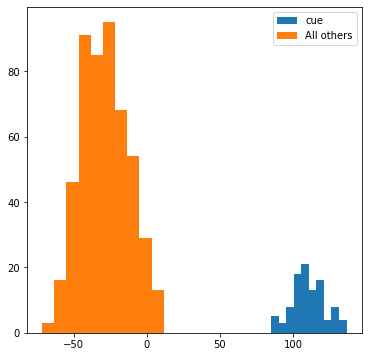

In [27]:
lda_data = fmri_coef@z; #(There is a built in method decision_variable that does this)
for j in range(nconditions):
    plt.figure(figsize = (6,6))
    plt.hist(lda_data[j,condition_index==j])
    plt.hist(lda_data[j,condition_index!=j])
    plt.legend((conditions[j],'All others'))
    plt.show()

#plt.hist(test[0,:][condition_index!=0],bins = np.arange(-20,20,1))
plt.show()

In [28]:
nnetworks = len(networks)
Accuracy_bynetwork = np.zeros(nnetworks)
for k in range(nnetworks):
    z_T = np.transpose(z[network_names == networks[k],:])
    kf = KFold(n_splits = 5,shuffle = True)
    errors = 0
    predictions = np.zeros(np.shape(z_T)[0])
    probability = np.zeros((len(predictions),2))
    clabel = np.zeros(np.shape(condition_index))
    clabel[condition_index < 4] = 0
    clabel[condition_index > 3] = 1
    for train_index, test_index in kf.split(z_T):
    #    print("TRAIN:", train_index, "TEST:", test_index)
        data_train = z_T[train_index]
        data_test = z_T[test_index]
        Label_train= clabel[train_index] 
        Label_test = clabel[test_index]
        lda = LDA(n_components=1)
        data_model = lda.fit(data_train, Label_train)
        predict = lda.predict(data_test)
        test = Label_test == predict
        errors = errors + sum(~test)
        predictions[test_index] = predict
        probability[test_index,:] = lda.predict_proba(data_test)
    errorrate = errors/len(condition_index)
    Accuracy_bynetwork[k] = 100*(1-errorrate)
for j in range(nnetworks):
    print(networks[j],Accuracy_bynetwork[j])

# those other brain areas they were hurting me the variance was affecting the classifer 

Auditory 73.33333333333334
Cingulo-Oper 94.66666666666667
Default 83.5
Dorsal-atten 69.16666666666667
Frontopariet 90.5
Language 76.5
Orbito-Affec 72.5
Posterior-Mu 92.5
Somatomotor 96.66666666666667
Ventral-Mult 76.66666666666666
Visual1 82.16666666666667
Visual2 83.16666666666667
